# Randomized Benchmarking

A **randomized benchmarking** (RB) experiment consists of the generation of random circuits on the given qubits such that the unitary computed by the circuits is the identity. After running the circuits, the number of shots resulting in an error (i.e. an output different than 0) are counted, and from this data one can infer error estimates for the quantum device.

In [1]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Running 1-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: abf7b29d-9290-4b07-b59f-0ad7ff392caf
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4782718902944065 ± 0.01004633345481035
- alpha: 0.9957949239506898 ± 0.00027289481043545473
- b: 0.5055896298447263 ± 0.009878787172442905
- analysis_type: RBAnalysis
- reduced_chisq: 0.14147445666597475
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.0021025380246550984
- EPC_err: 0.00013702359987575517
- EPG: {0: {'rz': 0.0, 'sx': 0.0004256862386201051, 'x': 0.0004256862386201051}}
- success: True


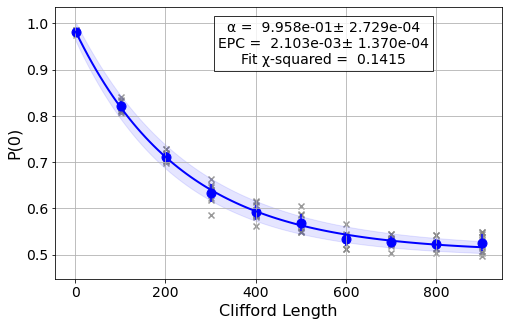

In [2]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]
# Run an RB experiment on qubit 0
exp1 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: b901d63a-7c8d-4dd9-bd50-3d2a765b6ce9
Status: DONE
Circuits: 70
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6952451961125841 ± 0.01789632746878643
- alpha: 0.9620800447715123 ± 0.0027131671966278605
- b: 0.265621527764627 ± 0.007597447056212205
- analysis_type: RBAnalysis
- reduced_chisq: 0.08493946538030113
- dof: 4
- xrange: [1.0, 181.0]
- EPC: 0.02843996642136576
- EPC_err: 0.002115079102336194
- EPG: {(1, 4): {'cx': 0.012912377310007167}}
- success: True
Backend's reported EPG: 0.012438847900902494
Experiment computed EPG: 0.012912377310007167


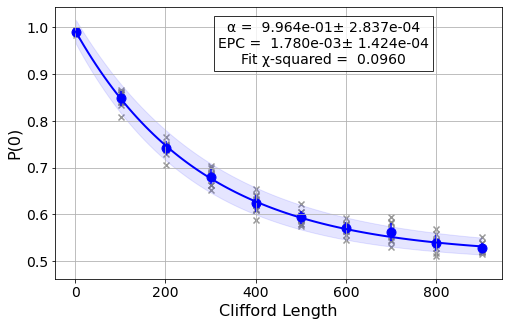

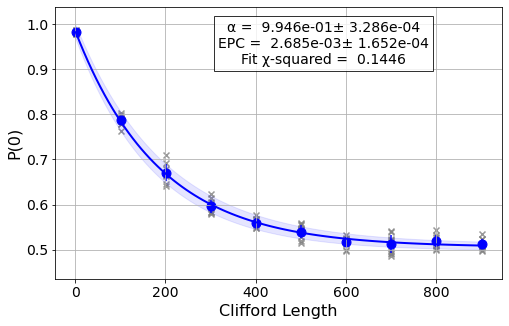

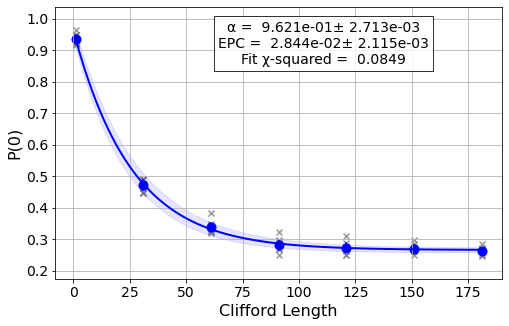

In [3]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
epg_data = {}
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in qubits:
    exp = rb.StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend)
    epg_data[qubit] = expdata.analysis_result(0)['EPG'][qubit]
    
# Run an RB experiment on qubits 1, 4
exp2 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_data)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Compare the computed EPG with the backend's recorded EPG:

expected_epg = rb.RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_result(0)['EPG'][qubits]['cx']
print("Backend's reported EPG:", expected_epg)
print("Experiment computed EPG:", exp2_epg)

# Displaying the RB circuits

Generating an example RB circuit:

In [4]:
# Run an RB experiment on qubit 0
exp = rb.StandardRB(qubits=[0], lengths=[10], num_samples=1, seed=seed)
c = exp.circuits()[0]

We transpile the circuit into the backend's basis gate set:

In [5]:
from qiskit import transpile
basis_gates = backend.configuration().basis_gates
print(transpile(c, basis_gates=basis_gates))

global phase: π/2
         ░ ┌──────────┐┌────┐┌───────┐ ░ ┌────┐┌─────────┐ ░ ┌──────────┐┌────┐»
   q_0: ─░─┤ RZ(3π/2) ├┤ √X ├┤ RZ(π) ├─░─┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├┤ √X ├»
         ░ └──────────┘└────┘└───────┘ ░ └────┘└─────────┘ ░ └──────────┘└────┘»
meas: 1/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌───────┐ ░ ┌────┐┌────┐┌───────┐ ░  ░ ┌─────────┐┌────┐ ░ ┌────┐»
«   q_0: ┤ RZ(π) ├─░─┤ √X ├┤ √X ├┤ RZ(π) ├─░──░─┤ RZ(π/2) ├┤ √X ├─░─┤ √X ├»
«        └───────┘ ░ └────┘└────┘└───────┘ ░  ░ └─────────┘└────┘ ░ └────┘»
«meas: 1/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌─────────┐ ░ ┌──────────┐ ░ ┌────┐┌──────────┐ ░ ┌────┐┌──────────┐»
«   q_0: ┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├»
«        └─────────┘ ░ └──────────┘ ░ └

# Running 1-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: 85cd0f14-7e1b-4ed3-859f-92638765c357
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4753293066993934 ± 0.006355152771438008
- alpha: 0.9958630812302494 ± 0.0001796240728321155
- alpha_c: 0.9990790406395462 ± 0.00021965960637795146
- b: 0.509299984859856 ± 0.006202979924905858
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.151815352926356
- dof: 16
- xrange: [1.0, 901.0]
- EPC: 0.00046047968022688845
- EPC_err: 0.00010982980318897573
- EPC_systematic_err: 0.003676439089523753
- EPC_systematic_bounds: [0, 0.0041369187697506415]
- success: True


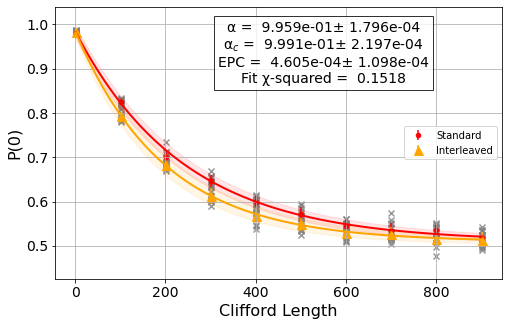

In [6]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

# Run an RB experiment on qubit 0
int_exp1 = rb.InterleavedRB(circuits.XGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

# Running 2-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: fdac184c-c7bc-4833-82c1-b5a8e23fadf8
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6838153822020804 ± 0.013471126025231879
- alpha: 0.9647509590775526 ± 0.0027886499804456164
- alpha_c: 0.9821305516766492 ± 0.0052485604965809155
- b: 0.2590684964893203 ± 0.005626402463663139
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.03070357008530445
- dof: 10
- xrange: [1.0, 181.0]
- EPC: 0.0134020862425131
- EPC_err: 0.003936420372435687
- EPC_systematic_err: 0.03947147514115801
- EPC_systematic_bounds: [0, 0.05287356138367111]
- success: True


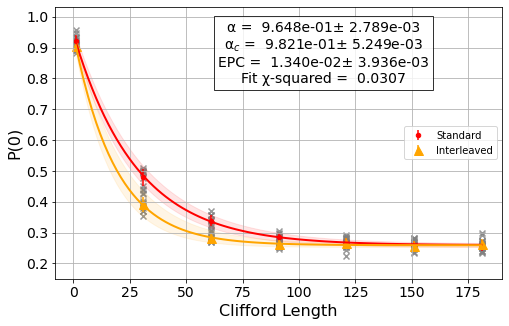

In [7]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [4,6]

# Run an Interleaved RB experiment on qubits 4, 6
int_exp2 = rb.InterleavedRB(circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

## Running parallel RB experiments

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: b3238c8c-cec5-4b8c-ac06-c66eb0eebc7b
Status: DONE
Component Experiments: 5
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['StandardRB', 'StandardRB', 'StandardRB', 'StandardRB', 'StandardRB']
- experiment_ids: ['05741def-e275-4372-b004-485f1794a357', '5bd5e4e2-3df8-457a-b5a4-bdc72a7f8a82', 'f5a5abd6-4c60-4976-9ac5-111068cea0e8', '89a4f753-01d4-4cde-bcea-5b9ebbbf9320', '8fd660bb-56a3-4a84-855f-8f43d37be187']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]
- success: True


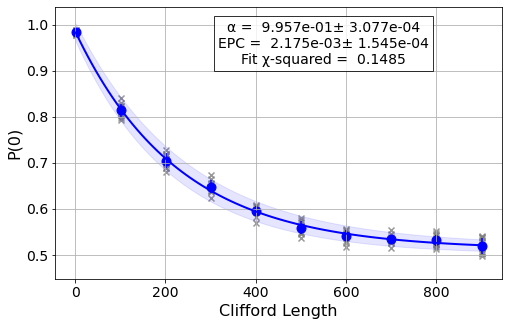

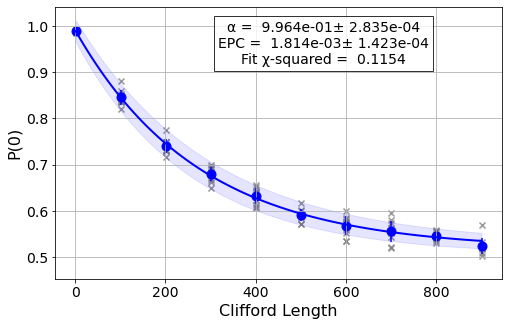

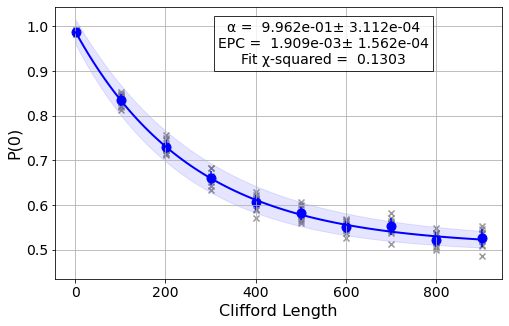

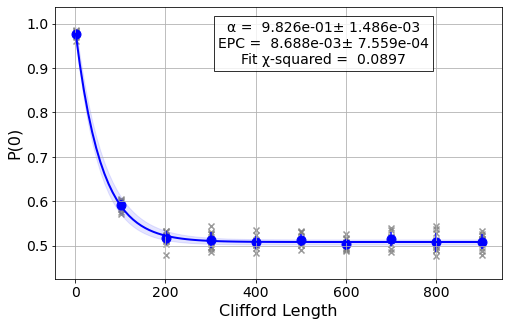

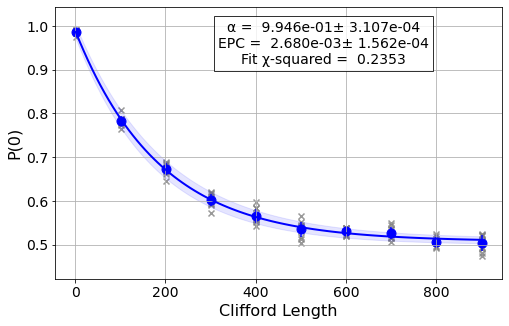

In [8]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = range(5)

exps = [rb.StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in qubits]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [9]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 05741def-e275-4372-b004-485f1794a357
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47369252694800973 ± 0.009957150915653221
- alpha: 0.9956504819082602 ± 0.0003077102704897544
- b: 0.5114128464506116 ± 0.009606623103381347
- analysis_type: RBAnalysis
- reduced_chisq: 0.14851207883897466
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.0021747590458698896
- EPC_err: 0.0001545272543332666
- EPG: {0: {'rz': 0.0, 'sx': 0.0004403083260733251, 'x': 0.0004403083260733251}}
- success: True 

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 5bd5e4e2-3df8-457a-b5a4-bdc72a7f8a82
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47369966388433016 ± 0.011786878867629743
- alpha: 0.9963727988486681 ± 0.0002835255721757002
-